#  Demonstration notebook for qiskit_pulse

In [1]:
from qiskit import transpile, schedule, QuantumCircuit
from qiskit.circuit import Gate
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeHanoi
from qiskit import pulse
from qiskit.pulse.library import Gaussian, GaussianSquare
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#  Backend configuration

In [2]:
#Save an IBM Quantum account.
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService()

In [ ]:
service.active_account()

In [ ]:
service.backends()

In [ ]:
BACKEND = FakeHanoi()
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

In [ ]:
BACKEND = service.get_backend('ibm_kyoto')
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

In [ ]:
list(config.to_dict().keys())
#config.to_dict()
#config.to_dict()['backend_name']

# From quantum circuit to pulse schedule : Transpilation

## qubit mapping

In [2]:
BACKEND = FakeHanoi()
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

fake_hanoi 27 ['id', 'rz', 'sx', 'x', 'cx', 'reset']
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


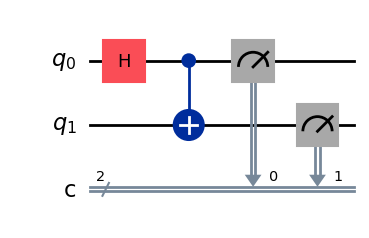

In [3]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)
circ.draw('mpl')

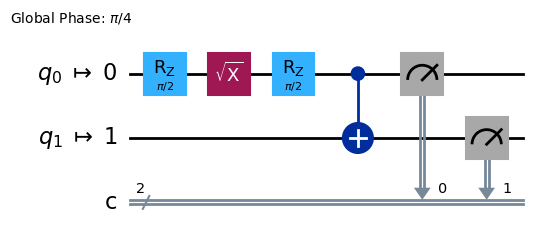

In [4]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

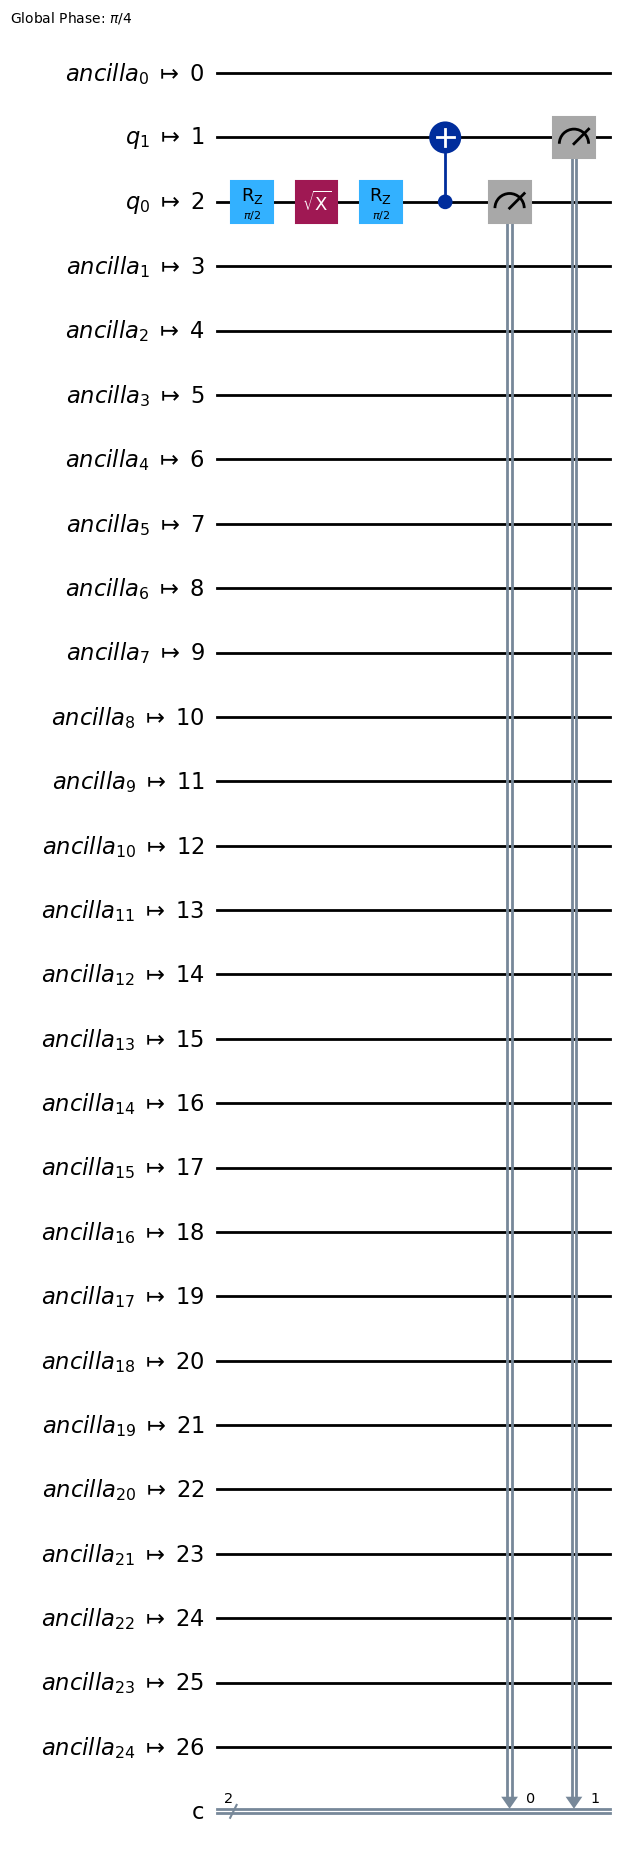

In [5]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[2,1])
transpiled_circ.draw('mpl', idle_wires=True)

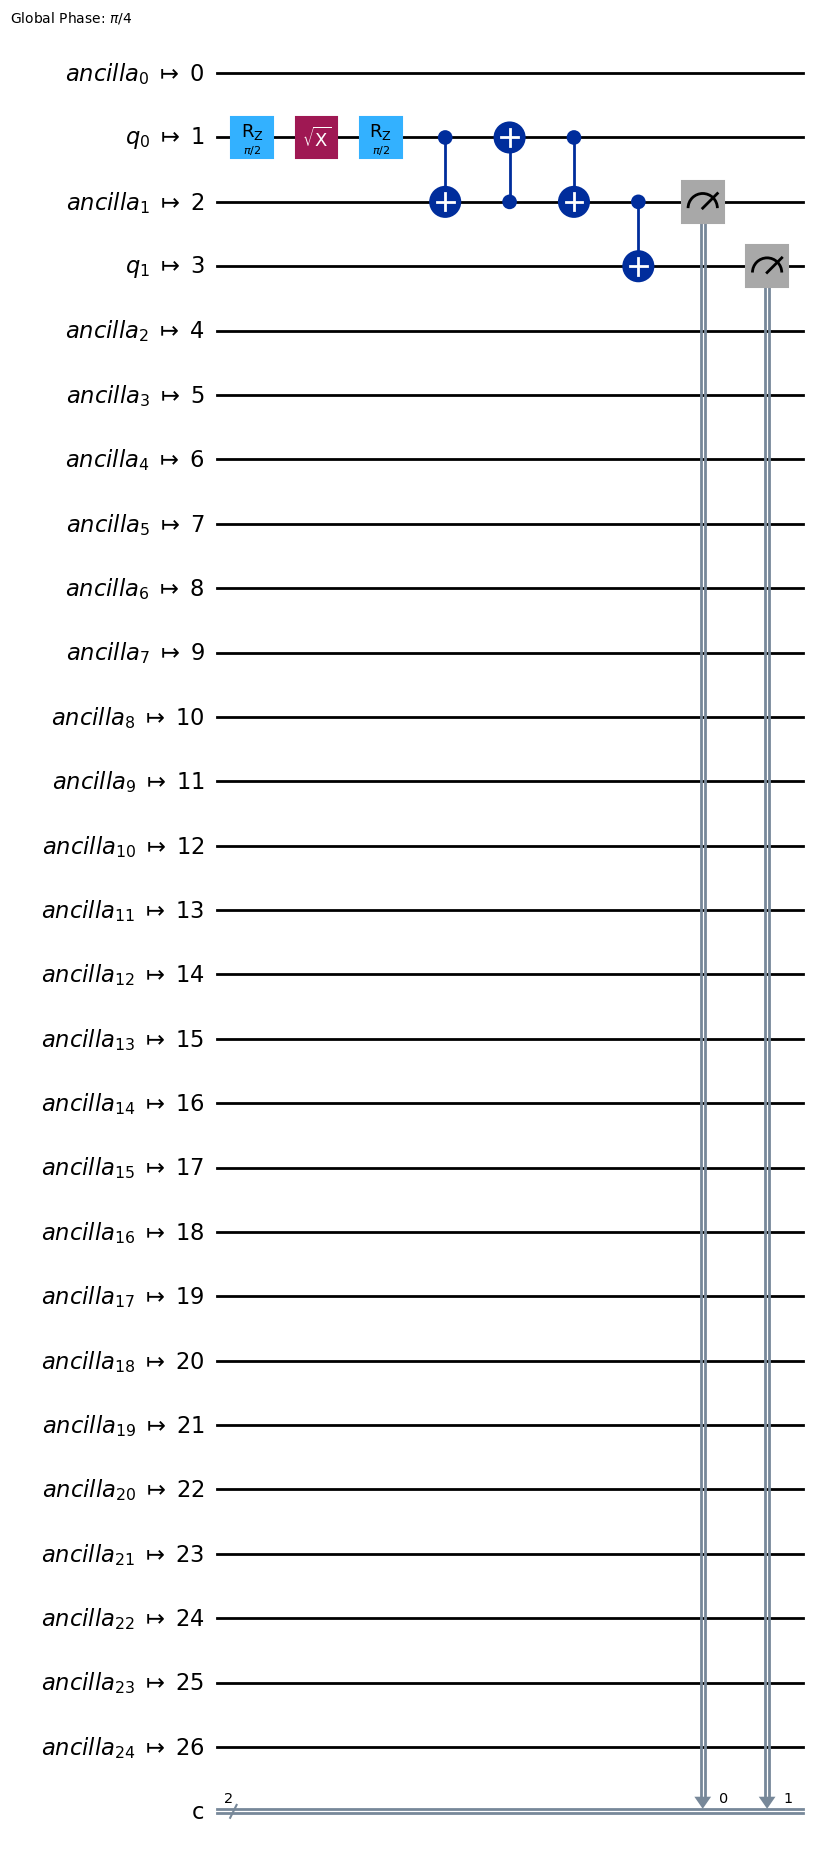

In [6]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[1,3])
transpiled_circ.draw('mpl', idle_wires=True)

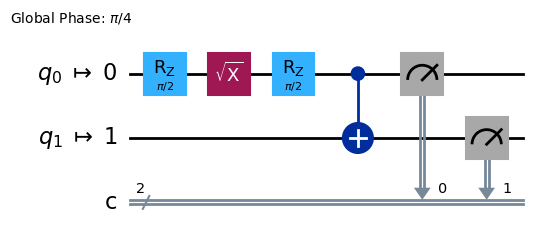

In [8]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

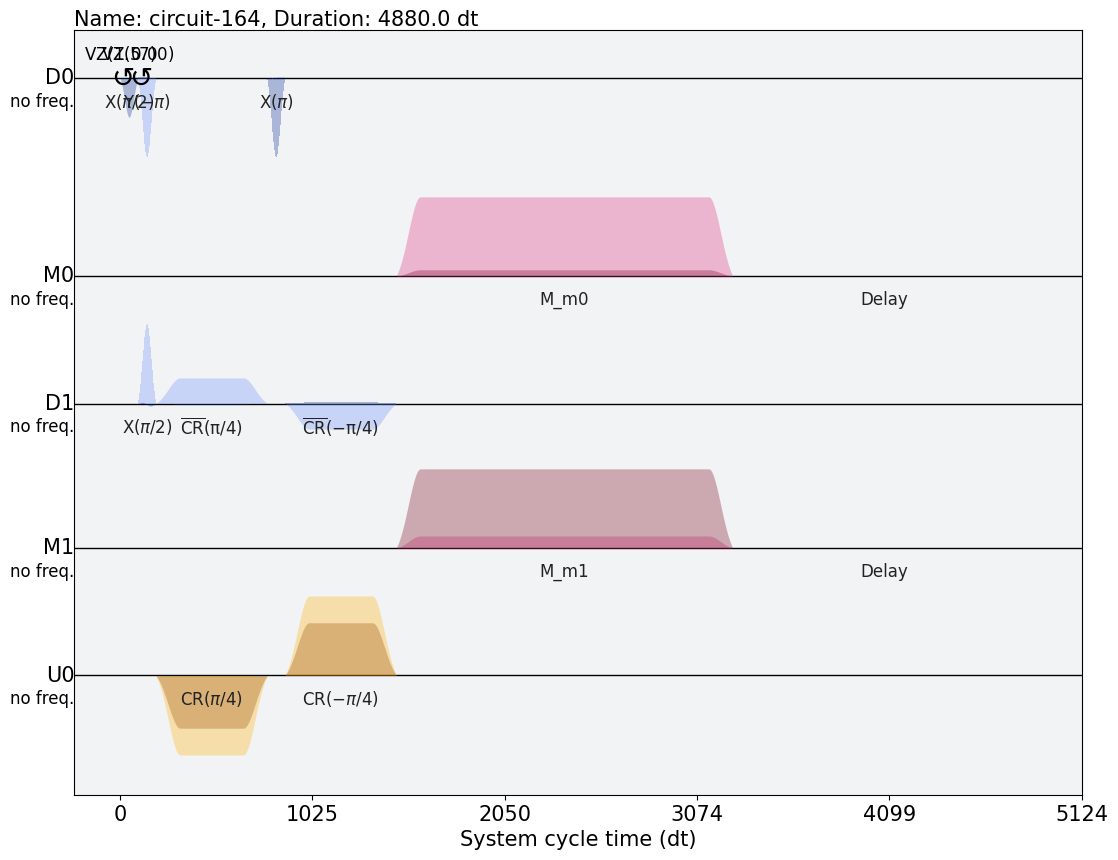

In [9]:
schedule(transpiled_circ, BACKEND).draw()

# How to build pulse gate : Transpilation on Fake Hanoi

In [10]:
BACKEND = FakeHanoi()
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

fake_hanoi 27 ['id', 'rz', 'sx', 'x', 'cx', 'reset']
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


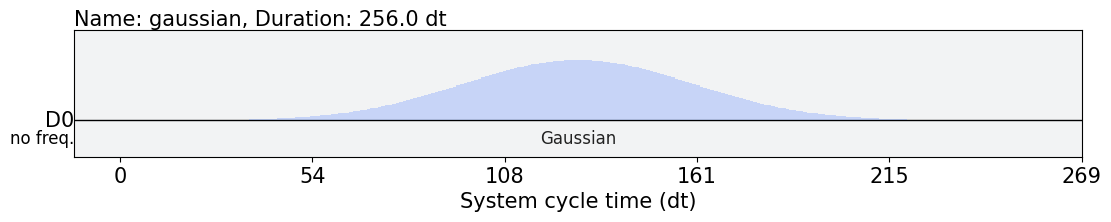

In [11]:
with pulse.build(BACKEND, name='gaussian') as gaussian_q0:
    pulse.play(Gaussian(duration=256, amp=0.2, sigma=128/4), pulse.drive_channel(0))
gaussian_q0.draw()

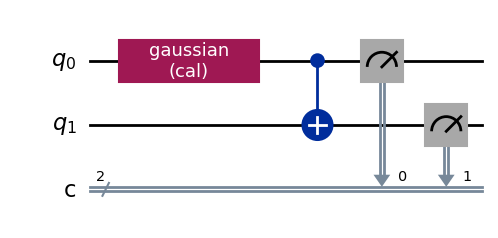

In [12]:
circ = QuantumCircuit(2, 2)
circ.append(Gate('gaussian', 1, []), [0])
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('gaussian', [0], gaussian_q0)
circ.draw('mpl')

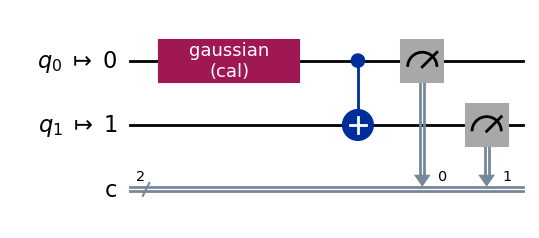

In [13]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

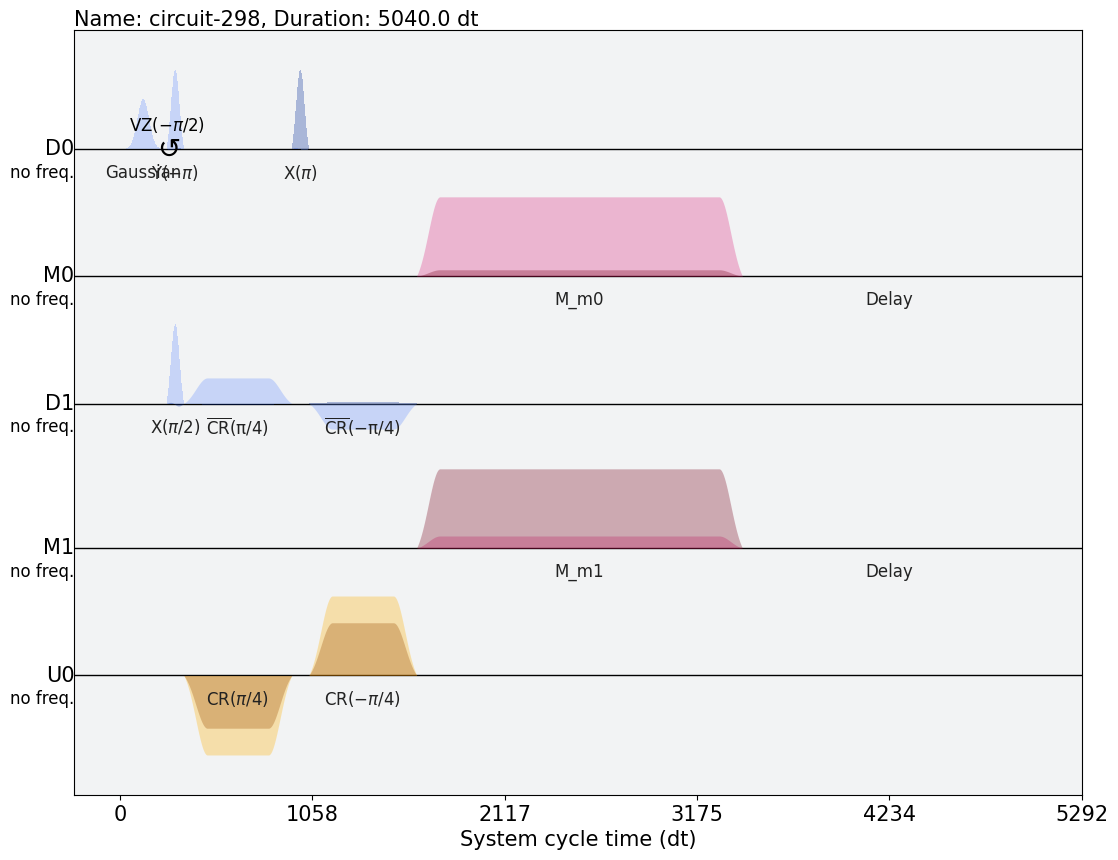

In [14]:
schedule(transpiled_circ, BACKEND).draw()

In [15]:
job = BACKEND.run(transpiled_circ)

In [16]:
job.status()

<JobStatus.ERROR: 'job incurred error'>

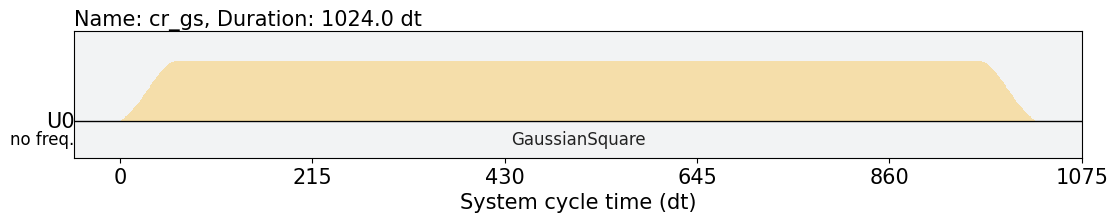

In [17]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q01:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(0,1)[0])
cr_gs_q01.draw()

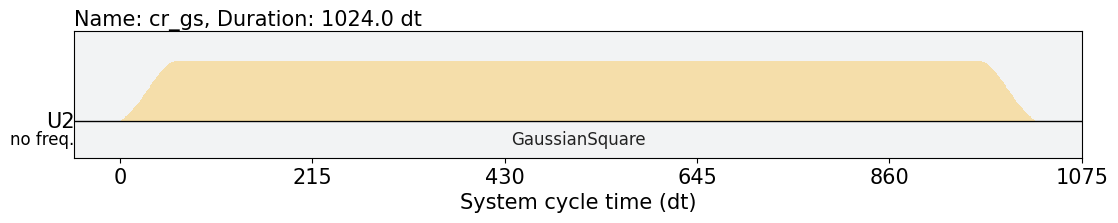

In [18]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q12:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(1,2)[0])
cr_gs_q12.draw()

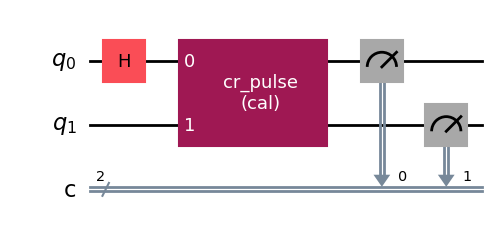

In [19]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.append(Gate('cr_pulse', 2, []), [0,1])
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('cr_pulse', [0,1], cr_gs_q01)
#circ.add_calibration('cr_pulse', [1,2], cr_gs_q12)
circ.draw('mpl')

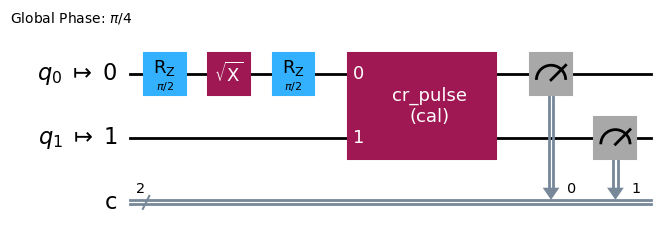

In [20]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

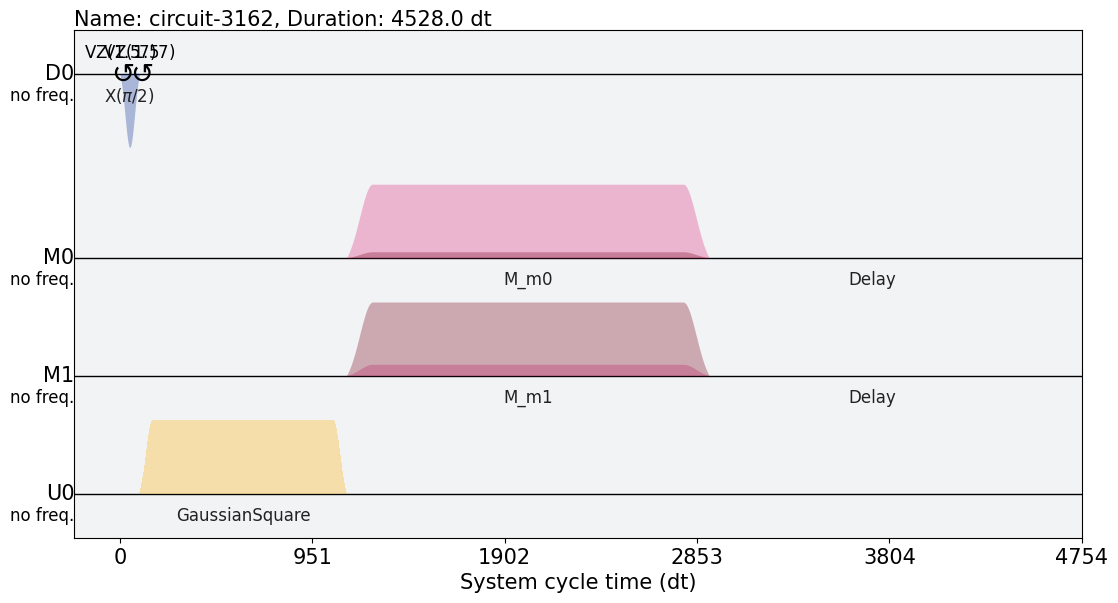

In [21]:
schedule(transpiled_circ, BACKEND).draw()

In [22]:
job = BACKEND.run(transpiled_circ)

In [23]:
job.status()

<JobStatus.ERROR: 'job incurred error'>

# Run on real device :: ibm_kyoto

In [30]:
BACKEND = service.get_backend('ibm_kyoto')

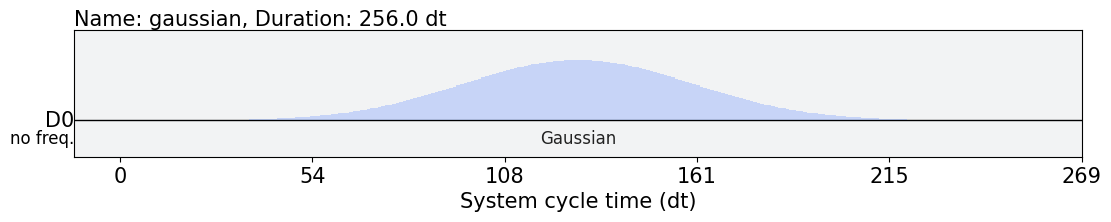

In [31]:
with pulse.build(BACKEND, name='gaussian') as gaussian_q0:
    pulse.play(Gaussian(duration=256, amp=0.2, sigma=128/4), pulse.drive_channel(0))
gaussian_q0.draw()

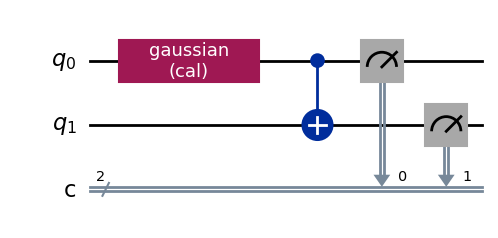

In [32]:
circ = QuantumCircuit(2, 2)
circ.append(Gate('gaussian', 1, []), [0])
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('gaussian', [0], gaussian_q0)
circ.draw('mpl')

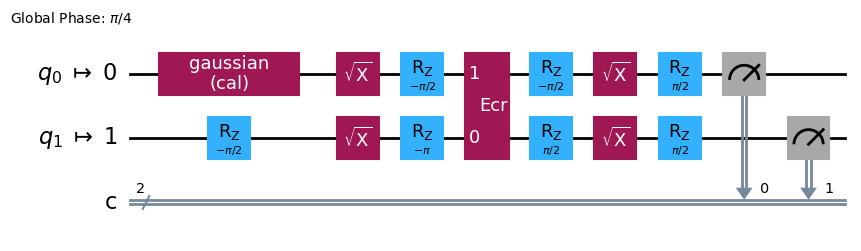

In [33]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

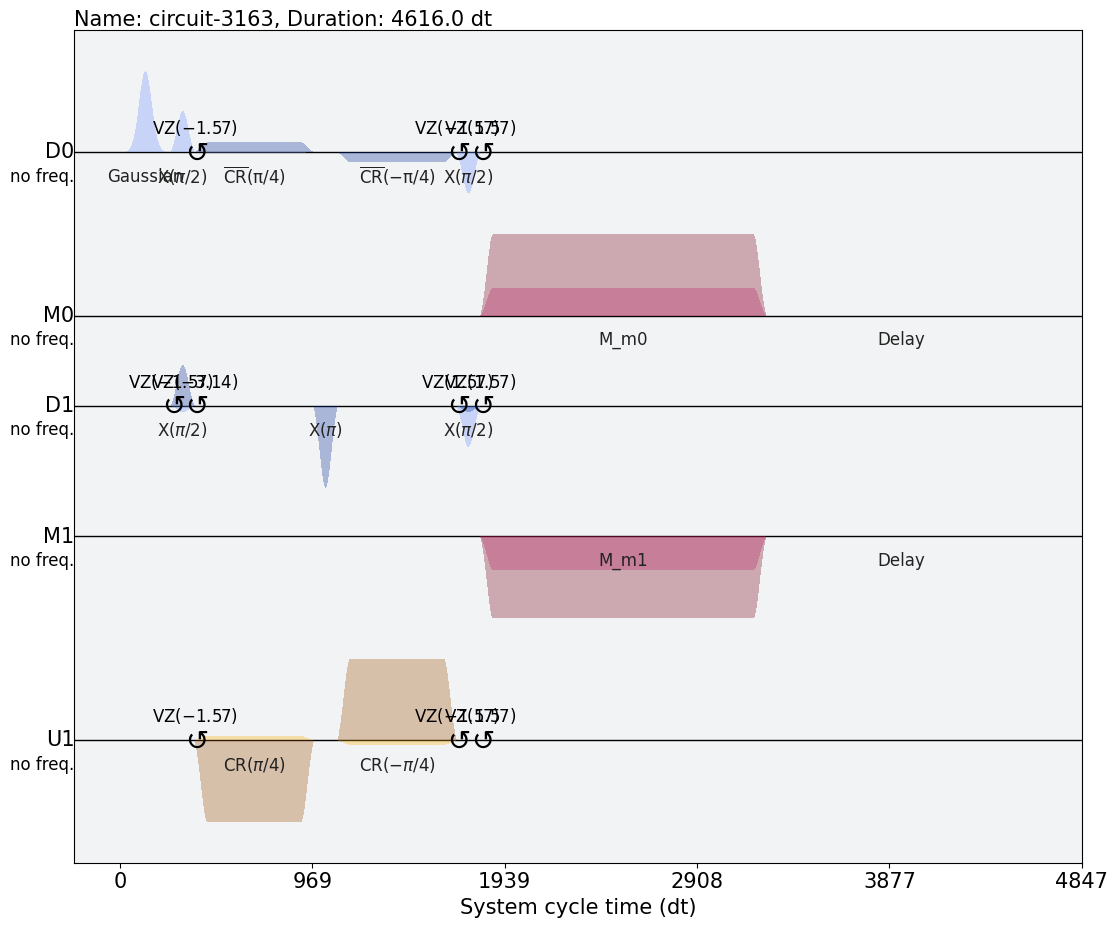

In [34]:
schedule(transpiled_circ, BACKEND).draw()

In [35]:
#job = BACKEND.run(transpiled_circ)

In [36]:
job = service.job('cqj4w89p36rg0086yn20')
job.status()

<JobStatus.DONE: 'job has successfully run'>

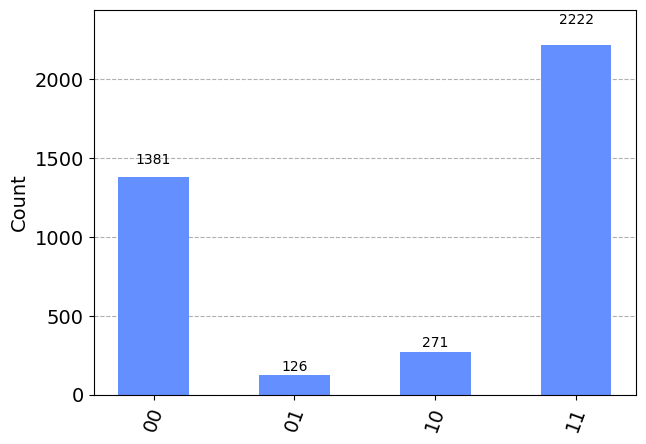

In [37]:
counts = job.result().get_counts()
plot_histogram(counts)

In [38]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q01:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(0,1)[0])
cr_gs_q01.draw()

BackendConfigurationError: "Couldn't find the ControlChannel operating on qubits (0, 1) on 127-qubit system. The ControlChannel information is retrieved from the backend."

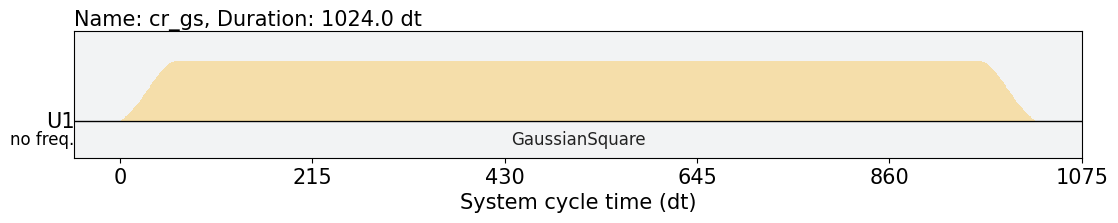

In [39]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q01:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(1,0)[0])
cr_gs_q01.draw()

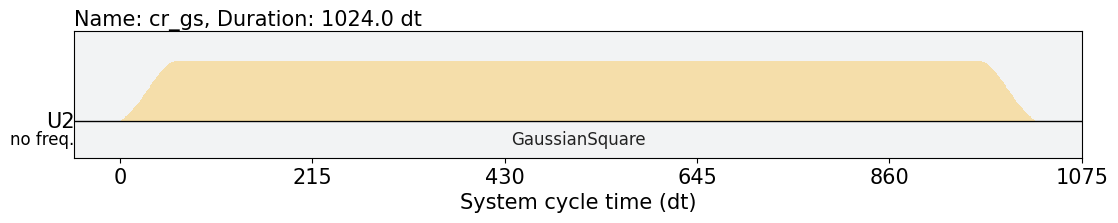

In [40]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q12:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(1,2)[0])
cr_gs_q12.draw()

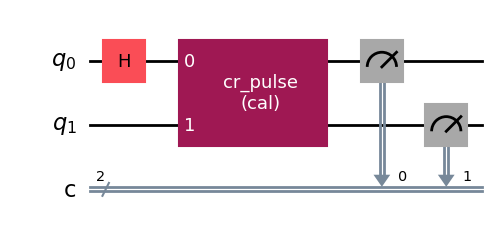

In [41]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.append(Gate('cr_pulse', 2, []), [0,1])
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('cr_pulse', [0,1], cr_gs_q01)
circ.add_calibration('cr_pulse', [1,2], cr_gs_q12)
circ.draw('mpl')

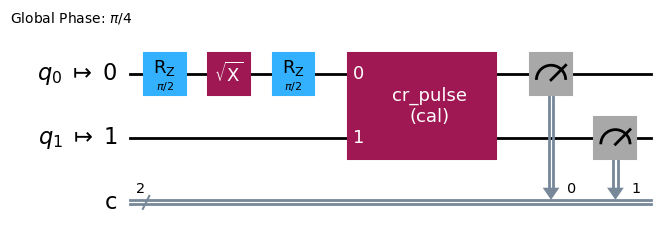

In [42]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

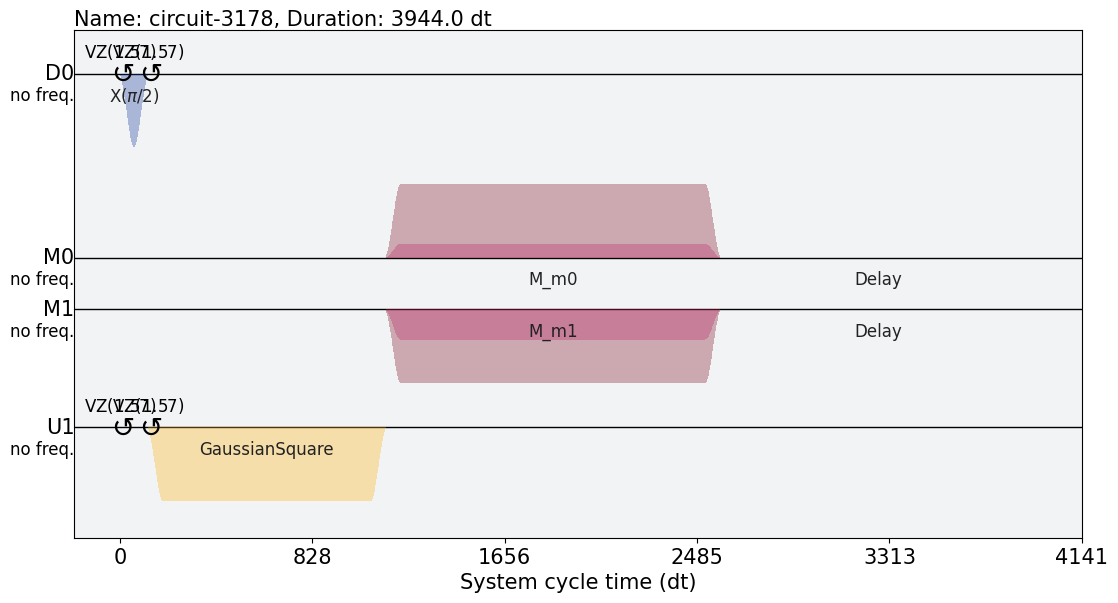

In [43]:
schedule(transpiled_circ, BACKEND).draw()

In [44]:
#job = BACKEND.run(transpiled_circ)
#job.job_id()

In [1]:
job = service.job('cqj4z1459d1g008jtstg')
job.status()

NameError: name 'service' is not defined

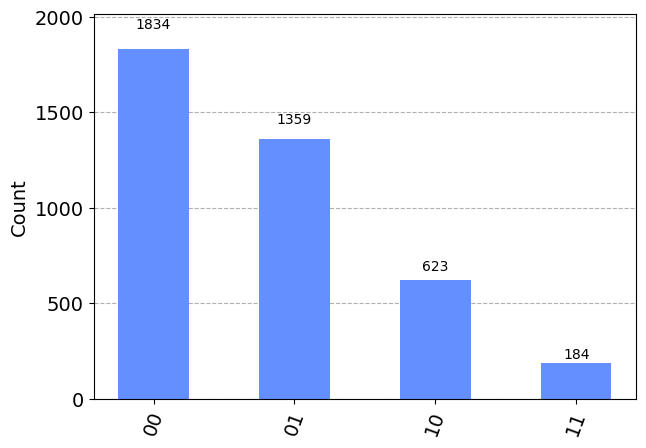

In [46]:
counts = job.result().get_counts()
plot_histogram(counts)

In [51]:
from qiskit.visualization import plot_state_city
#from qiskit_experiments.framework import ParallelExperiment, ExperimentStatus
from qiskit_experiments.library import StateTomography, MitigatedStateTomography

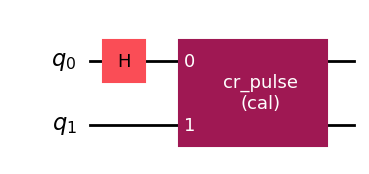

In [52]:
circ = QuantumCircuit(2)
circ.h(0)
circ.append(Gate('cr_pulse', 2, []), [0,1])
circ.add_calibration('cr_pulse', [0,1], cr_gs_q01)
circ.draw('mpl')

In [53]:
# QST Experiment
qst_exp = StateTomography(circ, BACKEND, [0,1])
qst_data = qst_exp.run(BACKEND)

In [60]:
qst_data.job_ids, qst_data.status()

(['cqk717cj3bz00085dxv0'],
 <ExperimentStatus.DONE: 'experiment jobs and analysis have successfully run'>)

In [61]:
# Print results
for result in qst_data.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 0.41829167+0.j        ,  0.25329167+0.00420833j,
                 0.01404167-0.00891667j, -0.011625  -0.013375j  ],
               [ 0.25329167-0.00420833j,  0.402625  +0.j        ,
                 0.030375  -0.006375j  ,  0.00104167+0.00258333j],
               [ 0.01404167+0.00891667j,  0.030375  +0.006375j  ,
                 0.092875  +0.j        , -0.01770833+0.00795833j],
               [-0.011625  +0.013375j  ,  0.00104167-0.00258333j,
                -0.01770833-0.00795833j,  0.08620833+0.j        ]],
              dims=(2, 2))
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: positive
- value: True
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1']
- verified: False


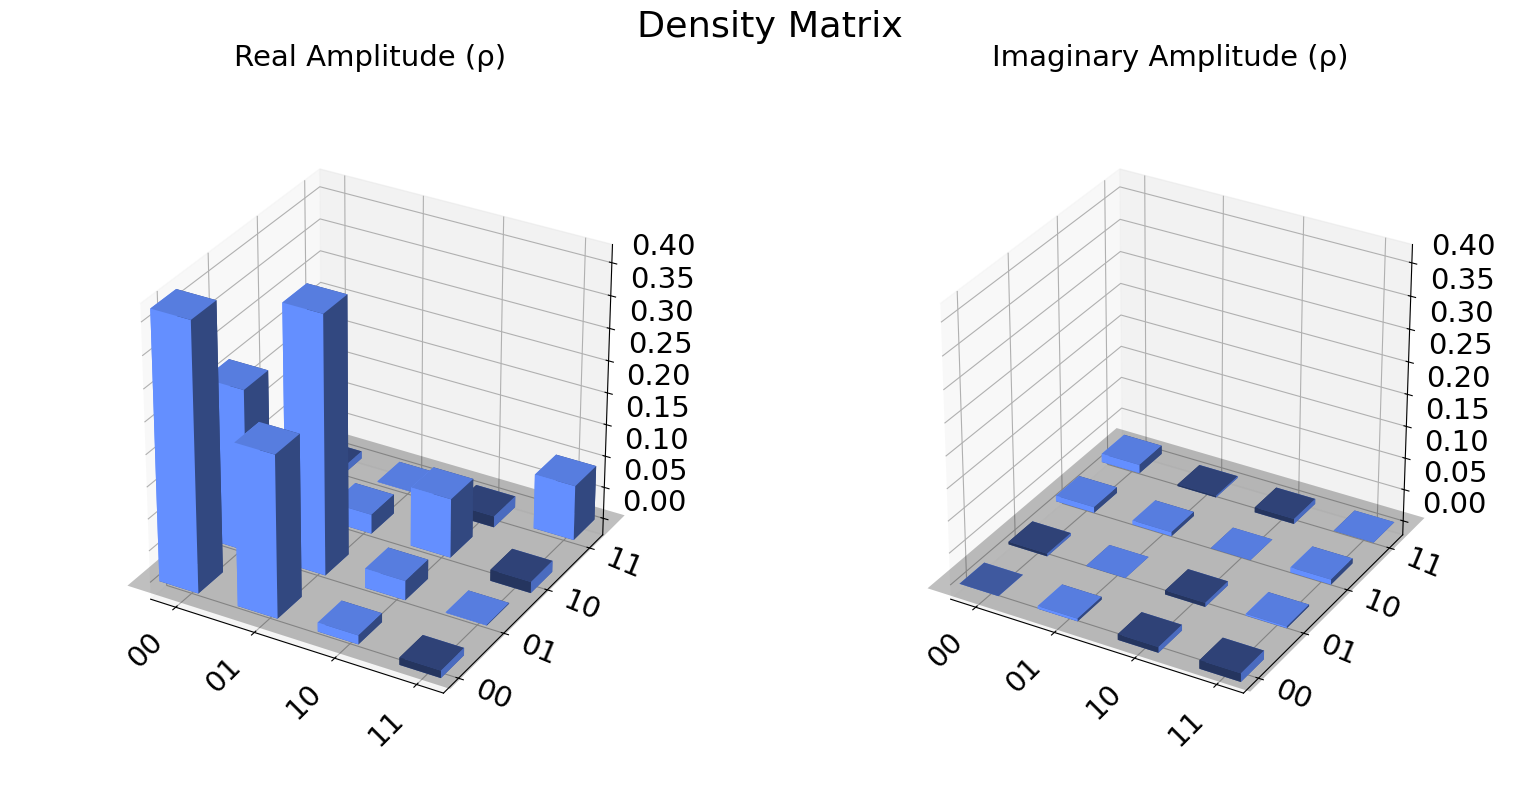

In [63]:
from qiskit.visualization import plot_state_city
plot_state_city(qst_data.analysis_results("state").value, title='Density Matrix')

# Rabi Oscillation Experiments

## Utility functions

In [45]:
def gaussian_pulse_circ(amp, duration, risefall): 
    with pulse.build(BACKEND, name='gaussian') as gaussian:
        pulse.play(Gaussian(duration=duration, amp=amp, sigma=risefall/4), pulse.drive_channel(QUBIT))
    
    circ = QuantumCircuit(1,1)
    circ.name = 'gaussian(%.2f,%d,%d)'%(amp, duration, risefall)
    circ.append(Gate('gaussian', 1, []), [0])
    circ.measure(0,0)
    circ.add_calibration('gaussian', [QUBIT], gaussian)
    return circ

def amp_scan_experiment(amp_step, duration=256, risefall=128, n=100):
    circs = [gaussian_pulse_circ(amp_step*i, duration, risefall) for i in range(100)]
    transpiled_circs = [transpile(circ, BACKEND, initial_layout=[QUBIT]) for circ in circs]
    job = BACKEND.run(transpiled_circs)
    print(job.job_id())
    return job

In [46]:
def gaussian_square_pulse_circ(amp, duration, risefall): 
    with pulse.build(BACKEND, name='gaussian_square') as gaussian_square:
        pulse.play(GaussianSquare(duration=duration, amp=amp, sigma=risefall/4, width=duration-risefall), pulse.drive_channel(QUBIT))
    
    circ = QuantumCircuit(1,1)
    circ.name = 'gaussian_sqaure(%.2f,%d,%d)'%(amp, duration, risefall)
    circ.append(Gate('gaussian_square', 1, []), [0])
    circ.measure(0,0)
    circ.add_calibration('gaussian_square', [QUBIT], gaussian_square)
    return circ

def duration_scan_experiment(duration_step, amp=0.05, risefall=128, n=100):
    circs = [gaussian_square_pulse_circ(amp, risefall+i*duration_step, risefall) for i in range(100)]
    transpiled_circs = [transpile(circ, BACKEND, initial_layout=[QUBIT]) for circ in circs]
    job = BACKEND.run(transpiled_circs)
    print(job.job_id())
    return job

In [47]:
def plot_population(counts):
    shots = sum(counts[0].values())
    pop0_list = [count['0']/shots for count in counts]
    pop1_list = [count['1']/shots for count in counts]
    plt.plot(pop0_list,  marker='o', label='|0>', linestyle = ":")
    plt.plot(pop1_list,  marker='o', label='|1>', linestyle = ":")
    plt.ylabel('Population')
    plt.ylim([-0.05, 1.05])
    plt.legend()

## Experiments on ibm_kyoto

In [49]:
BACKEND = service.get_backend('ibm_kyoto')

### Duration_scan

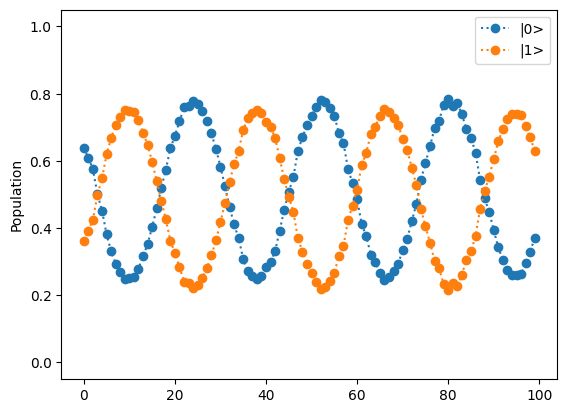

In [51]:
QUBIT = 0
#job = duration_scan_experiment(duration_step=16)
job = service.job('cqj3wnj2n5m0008j3pqg')
#job.status()
plot_population(job.result().get_counts())

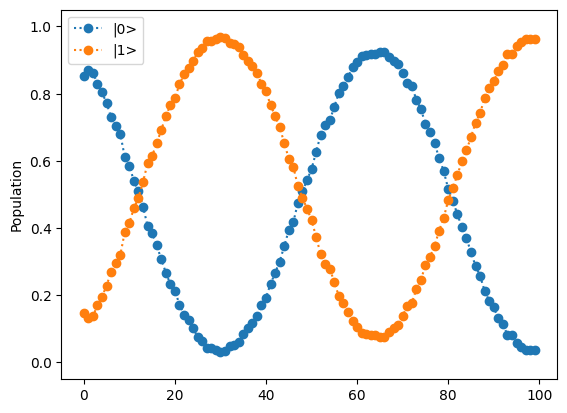

In [52]:
QUBIT = 1
#job = duration_scan_experiment(duration_step=16)
job = service.job('cqj3wkt2n5m0008j3ppg')
#job.status()
plot_population(job.result().get_counts())

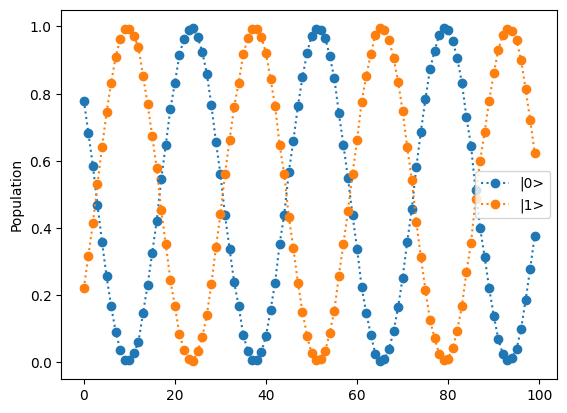

In [53]:
QUBIT = 2
#job = duration_scan_experiment(duration_step=16)
job = service.job('cqj3wjj2n5m0008j3pp0')
#job.status()
plot_population(job.result().get_counts())

### Amplitude_scan

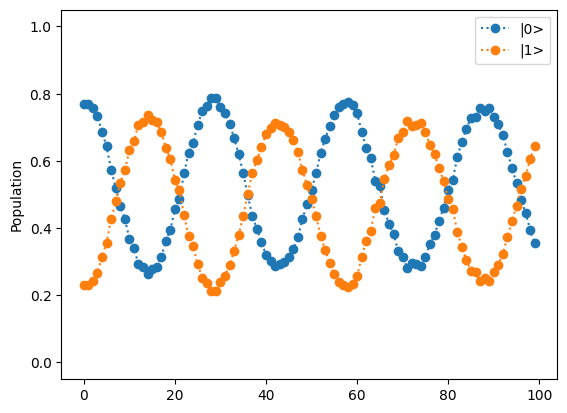

In [471]:
QUBIT = 0
#job = amp_scan_experiment(amp_step=0.01)
job = service.job('cqhgav3p36rg0086v2n0')
counts = job.result().get_counts()
plot_population(counts)

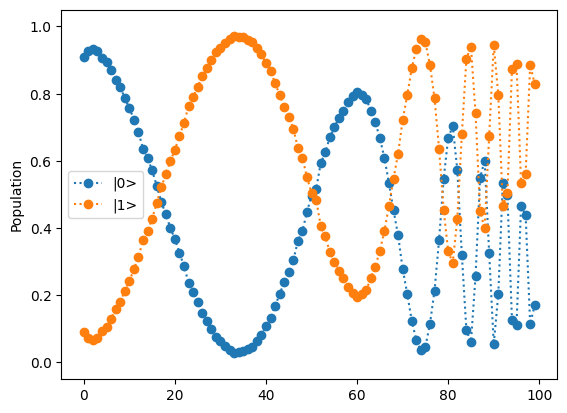

In [468]:
QUBIT = 1
#job = amp_scan_experiment(amp_step=0.01)
job = service.job('cqhg9ppv3xv000861ngg')
counts = job.result().get_counts()
plot_population(counts)

In [54]:
QUBIT = 2
#job = amp_scan_experiment(amp_step=0.01)
job = service.job('cqjq70mp36rg00871j80')
job.status()
#plot_population(job.result().get_counts())

<JobStatus.QUEUED: 'job is queued'>

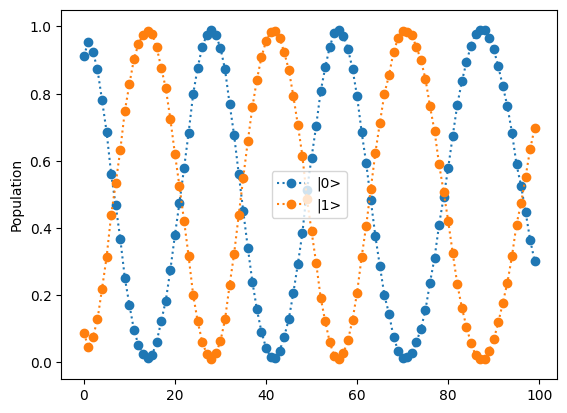

In [50]:
QUBIT = 2
#job = amp_scan_experiment(amp_step=0.01)
job = service.job('cqjnbxfv3xv000867rdg')
#job.status()
plot_population(job.result().get_counts())

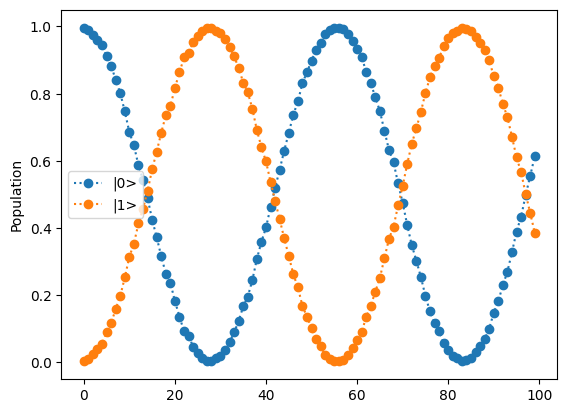

In [56]:
#QUBIT = 2
#job = amp_scan_experiment(amp_step=0.005)
job = service.job('cqhg4hjp36rg0086v2eg')
plot_population(job.result().get_counts())

## Experiments on ibm_osaka

In [192]:
BACKEND = service.get_backend('ibm_osaka')

### Duration_scan

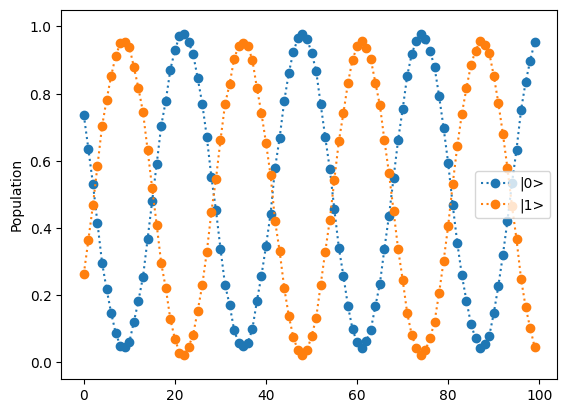

In [58]:
QUBIT = 0
#job = duration_scan_experiment(duration_step=16)
job = service.job('cqjhs6459d1g008jwq90')
#job.status()
plot_population(job.result().get_counts())